In [37]:
# import relevant libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random as rd
import os
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
rd.seed(100)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import ipywidgets as widgets
from IPython.display import display
from matplotlib.cm import get_cmap
from sklearn.decomposition import PCA
import flowkit as fk

In [38]:
# import data for viSNE
csv_path = r"C:\Users\bruno\OneDrive\Desktop\Programmer\viSNE_maps_and_data\Data\Data_Xinje\Some Data from Xinjie Project\Complete_data_set_for_ML"
definitions_dict = {
        "3B": 1,
        "3D": 2,
        "3G": 3,
        "A26": 4,
        "MP": 5,
        "CK":6,
        "CM":7,
        "FeOx":8,
        "Q12":9

    }

def label_data_according_to_definitions(csv_path,definitions_dict):
    """csv_path: contains the path of your csv files
        definitions_dict: contains the matching suffix or prefix (unique), which matches corresponding labels"""
    labeled_dfs = []
    

    for filename in os.listdir(csv_path):
        file_path = os.path.join(csv_path, filename)
        if filename.endswith(".csv"):  # Check if the file is a CSV file
            df = pd.read_csv(file_path)
            for key, label in definitions_dict.items():
                if key in filename:
                    df['Label'] = label  # Add a new column 'Label' with the corresponding label
                    labeled_dfs.append(df)
                    break  # No need to check other keys once a match is found

    return labeled_dfs


# label data 
labeld_dfs = label_data_according_to_definitions(csv_path,definitions_dict=definitions_dict)

In [75]:


def load_and_transform_fcs_from_dir(directory_path):
    fcs_files = []
    asinh_xform = fk.transforms.AsinhTransform('asinh', param_t=262144, param_m=4.0, param_a=0.0)
    # Iterate through files in the directory
    for file in os.listdir(directory_path):
        if file.endswith(".fcs"):
            file_path = os.path.join(directory_path, file)
            try:
                fcs_data = fk.Sample(file_path)
                fcs_data.apply_transform(asinh_xform)
                fcs_data_df = fcs_data.as_dataframe()
                fcs_data_df = fcs_data_df[[col for col in fcs_data_df.columns if col[0].endswith('-A')]]
                fcs_data_df.columns = fcs_data_df.columns.droplevel(0)
                fcs_files.append(fcs_data_df)
            except Exception as e:
                print(f"An error occurred while processing {file}: {e}")
    return fcs_files

direct = r"C:\Users\bruno\OneDrive\Desktop\Programmer\viSNE_maps_and_data\Data\fcm_field_data"
fcs_files = load_and_transform_fcs_from_dir(direct)

pns,FS,SS,FL1 510/20,FL2 542/27,FL3 575,FL4 620/30,FL5 695/30,FL6 660,FL7 725/20,FL8 755,FL9 450/50,FL10 525
0,0.906206,0.824182,0.537860,0.512165,0.642070,0.485053,0.434841,0.257712,0.344005,0.316893,0.495382,0.486235
1,0.902720,0.814241,0.668738,0.611138,0.740187,0.596861,0.304133,0.311640,0.230054,0.155008,0.644865,0.592639
2,0.889019,0.765894,0.749338,0.717779,0.744911,0.631301,0.267233,0.403885,0.308072,0.214275,0.633915,0.634792
3,0.921412,0.793412,0.682021,0.601333,0.687585,0.562953,0.797119,0.577334,0.637405,0.548962,0.546750,0.561364
4,0.888931,0.689922,0.791992,0.741994,0.766685,0.589179,0.634276,0.455652,0.475574,0.388616,0.555464,0.590212
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.966305,0.868890,0.765219,0.735566,0.763349,0.597538,0.667532,0.490702,0.511272,0.436711,0.564770,0.600663
9996,0.932788,0.866118,0.666804,0.638405,0.683834,0.511310,0.672295,0.451589,0.545912,0.475937,0.517122,0.525329
9997,0.906222,0.967064,0.581499,0.564084,0.662468,0.567139,0.171652,0.311873,0.194593,0.137906,0.597774,0.594163
9998,0.935236,0.948646,0.646629,0.663004,0.742550,0.620034,0.327309,0.427102,0.294989,0.239007,0.619732,0.603302


In [84]:
# write subsampling function

def subsample_from_list_of_df(list_of_dataframes, subsampling_number=300, random_seed=None):
    """
    Subsample rows from each DataFrame in a list and concatenate them together.

    Parameters:
    - list_of_dataframes: List of pandas DataFrames to subsample from.
    - subsampling_number: Number of rows to subsample from each DataFrame.
    - random_seed: Seed for random number generation (for reproducibility).

    Returns:
    - Concatenated DataFrame containing the subsampled rows.
    """
    # Set random seed for reproducibility
    if random_seed is not None:
        np.random.seed(random_seed)
    
    # Initialize an empty list to store the subsampled DataFrames
    subsampled_dfs = []
    
    for df in list_of_dataframes:
        # Check if the subsampling number is greater than the number of rows in the DataFrame
        if subsampling_number >= len(df):
            subsampled_dfs.append(df)  # Append the entire DataFrame
        else:
            # Randomly sample 'subsampling_number' rows without replacement
            subsampled_df = df.sample(n=subsampling_number, replace=False)
            subsampled_dfs.append(subsampled_df)
    
    # Concatenate the subsampled DataFrames into one DataFrame
    concatenated_df = pd.concat(subsampled_dfs, ignore_index=True)
    
    return concatenated_df

subsampling_df = subsample_from_list_of_df(labeld_dfs,subsampling_number=2000)
subsampling_df_fcs_transformed = subsample_from_list_of_df(fcs_files,subsampling_number=1500)

In [64]:
def asinh_transform(subsampling_df, factor=150):

    transformed_df = subsampling_df.copy()  # Create a copy to store the transformed data
    for col_name in subsampling_df.columns:
        if col_name != 'Label' and pd.api.types.is_numeric_dtype(subsampling_df[col_name]):
            col = subsampling_df[col_name]
            transformed_df[col_name] = np.arcsinh(col / factor )

            # 99th percentile normalization
            # percentile_99 = np.percentile(transformed_df[col_name], 99)
            # transformed_df[col_name] = transformed_df[col_name] / percentile_99


    return transformed_df

transformed_dataframes = asinh_transform(subsampling_df,factor=150)

In [85]:
# create tSNE map and contatenate dataframe with labels

perplexity_value = 30
input_matrix_for_TSNE = subsampling_df.iloc[:, :-1]
label_col = subsampling_df.iloc[:,-1]


In [86]:
tsne_result = TSNE(n_components=2, perplexity=perplexity_value, verbose=True).fit_transform(subsampling_df_fcs_transformed)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 78000 samples in 0.103s...


C:\Users\bruno\AppData\Local\Temp\ipykernel_19500\1425570943.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab10')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


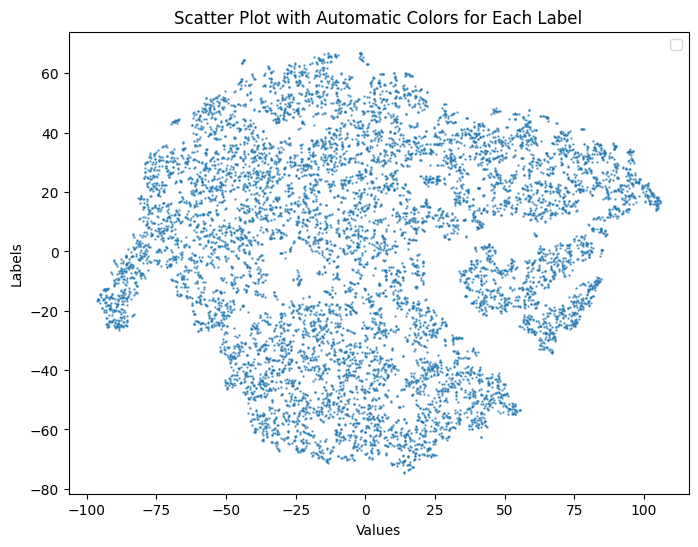

In [83]:
def plot_vsne_result_generic(tsne_result,label_col):

    x= tsne_result[:, 0]
    y= tsne_result[:, 1]
    cmap = get_cmap('tab10')


    # Create a scatter plot with automatic colors for each label
    plt.figure(figsize=(8, 6))

    # Get unique labels
    if label_col is not None:
        unique_labels = label_col.unique()
    # Scatter plot with automatic colors
        for i, label in enumerate(unique_labels):
            plt.scatter(x[label_col == label], y[label_col == label], label=label, color=cmap(i), alpha=0.7,s= 0.5)
    else:
        plt.scatter(x, y,alpha=0.7,s= 0.5)

    # Customize plot labels and title
    plt.xlabel('Values')
    plt.ylabel('Labels')
    plt.title('Scatter Plot with Automatic Colors for Each Label')

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()

plot_vsne_result_generic(tsne_result,label_col=None)

In [74]:
# create interactive plot to change coloring scheme with a dropdown menu 
def create_visne_with_dropdown(tsne_result,subsampling_df):
        """ creates viSNE Map with coloring according to different input columns which can be switched through a dropdown menu
        args:
        tsne_result: Coordidnates in the viSNE Map created from subsampling_df
        subsampling_df: a df of subsampled accordingly from original dataframes"""
        data = {
                "X1":tsne_result[:,0],
                "X2":tsne_result[:,1]

        }

        df = pd.DataFrame(data)

        color_matrix = subsampling_df

        def update_scatter_plot(selected_col_for_coloring):
                plt.figure(figsize=(8,6))
                scatter = plt.scatter(df["X1"], df["X2"], c = color_matrix[selected_col_for_coloring], cmap="rainbow",s=0.01)
                plt.colorbar(scatter,label="Strenght")
                plt.show()

        coloring_scheme = widgets.Dropdown(
                options = color_matrix.columns,
                description = "Select Col for coloring: ",
                continuous_update = False

        )

        widgets.interactive(update_scatter_plot,selected_col_for_coloring=coloring_scheme)
        interactive_plot = widgets.interactive(update_scatter_plot, selected_col_for_coloring=coloring_scheme)
        return interactive_plot
    
    # Display the interactive widget

create_visne_with_dropdown(tsne_result,subsampling_df_fcs_transformed)

<Figure size 800x600 with 0 Axes>

interactive(children=(Dropdown(description='Select Col for coloring: ', options=(('FS-A', 'FS'), ('SS-A', 'SS'…

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

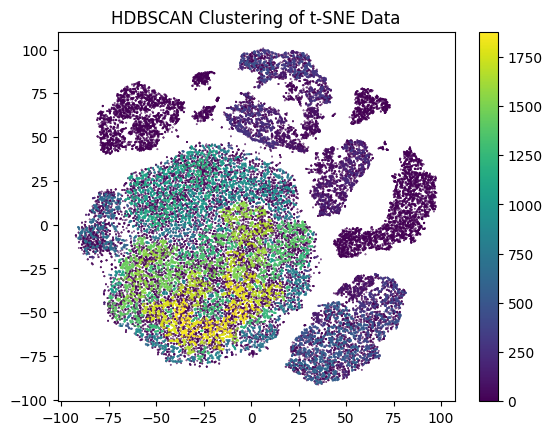

In [14]:
# automatic clustering 
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=5)
cluster_labels = clusterer.fit_predict(tsne_result)

# Visualize the clusters
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=cluster_labels, cmap='viridis', marker='.', s= 0.5)
plt.colorbar()
plt.title('HDBSCAN Clustering of t-SNE Data')
plt.show()

In [15]:
# implement clustering based on mchine learning$

# implement machine learning model, use Y to predict labels

labeld_dfs = transformed_dataframes
combined_df = pd.concat(labeld_dfs,ignore_index=True)
combined_df_rand= combined_df.sample(frac=1,random_state=42).reset_index(drop=True)
train_df, test_df = train_test_split(combined_df_rand,test_size=0.2,random_state=42)
X_train = train_df.drop("Label",axis=1)
y_train = train_df["Label"]

X_test = test_df.drop("Label", axis=1)
y_test = test_df["Label"]


rf_class= RandomForestClassifier(n_estimators=200, random_state=42)

rf_class.fit(X_train,y_train)


y_pred = rf_class.predict(X_test)

accuracy = accuracy_score(y_test,y_pred)
report = classification_report(y_test,y_pred)

print(f"accuracy:{accuracy:.2f}")
print("Classification Report:")
print(report)


accuracy:0.83
Classification Report:
              precision    recall  f1-score   support

           1       0.97      0.98      0.97      5695
           2       0.96      0.99      0.98      3035
           3       0.99      0.98      0.98      1966
           4       0.97      0.93      0.95      3885
           5       0.86      0.92      0.89     11878
           6       0.73      0.67      0.70      5953
           7       0.71      0.69      0.70      6067
           8       0.79      0.78      0.79      4799
           9       0.63      0.63      0.63      6000

    accuracy                           0.83     49278
   macro avg       0.85      0.84      0.84     49278
weighted avg       0.82      0.83      0.82     49278



In [68]:
dir_data= r"C:\Users\bruno\OneDrive\Desktop\Programmer\viSNE_maps_and_data\Data\fcm_field_data\Extracted_Data"

# load csv only ending with e 
def load_csv_with_ending(dir_data,ending="_e"):
    input_df = []
    for filename in os.listdir(dir_data):
        file_path = os.path.join(dir_data, filename)
        if filename.endswith(f"{ending}.csv"):  # Check if the file is a CSV file
            df = pd.read_csv(file_path)
            
            # Add a new column 'filename' with the current filename
            df['filename'] = filename
            
            input_df.append(df)
    return input_df

input_df = load_csv_with_ending(dir_data)
print(len(input_df))
z=input_df[50]
subsampling_input_df= subsample_from_list_of_df(input_df,1000,42)
input_df_transformed= asinh_transform(subsampling_input_df,factor=150)

51


In [30]:
def rename_columns(input_df, column_mapping):
    # Create a copy of the DataFrame to avoid modifying the original
    renamed_df = input_df.copy()
    
    # Rename columns based on the provided mapping
    renamed_df.rename(columns=column_mapping, inplace=True)
    
    return renamed_df

# Define the mapping from current column names to expected feature names
column_mapping = {
    'FL3': 'FL3 575',
    'FL5': 'FL5 695/30'
}

# Call the function to rename the columns
subsampling_input_df = rename_columns(subsampling_input_df, column_mapping)

In [18]:


ML_labels = rf_class.predict(subsampling_input_df.iloc[:,:-2])

subsampling_input_df["ML_Labels"]= ML_labels

In [61]:
# create viSNE map with dropdown for all cols, hdbscan analysis, ML labeling
input_matrix = input_df_transformed.iloc[:,:-1]
tsne_result_input = TSNE(n_components=2, perplexity=30, verbose=True,method="barnes_hut").fit_transform(input_matrix)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 51000 samples in 0.059s...
[t-SNE] Computed neighbors for 51000 samples in 8.114s...
[t-SNE] Computed conditional probabilities for sample 1000 / 51000
[t-SNE] Computed conditional probabilities for sample 2000 / 51000
[t-SNE] Computed conditional probabilities for sample 3000 / 51000
[t-SNE] Computed conditional probabilities for sample 4000 / 51000
[t-SNE] Computed conditional probabilities for sample 5000 / 51000
[t-SNE] Computed conditional probabilities for sample 6000 / 51000
[t-SNE] Computed conditional probabilities for sample 7000 / 51000
[t-SNE] Computed conditional probabilities for sample 8000 / 51000
[t-SNE] Computed conditional probabilities for sample 9000 / 51000
[t-SNE] Computed conditional probabilities for sample 10000 / 51000
[t-SNE] Computed conditional probabilities for sample 11000 / 51000
[t-SNE] Computed conditional probabilities for sample 12000 / 51000
[t-SNE] Computed conditional probabilities for sam

In [ ]:
plot_vsne_result_generic(tsne_result_input,label_col=subsampling_input_df)

In [63]:
i_plot = create_visne_with_dropdown(tsne_result_input,input_matrix)
display(i_plot)

interactive(children=(Dropdown(description='Select Col for coloring: ', options=('FS', 'SS', 'FL1 510/20', 'FL…